In [1]:
import pandas as pd
import xarray as xr
import numpy as np

import matplotlib.pyplot as plt
import cartopy.crs as ccrs


In [2]:
dir_list_df = pd.read_csv('/user/ab5405/summeraliaclimate/code/dir_list.csv', index_col=0)
dir_list = dir_list_df['dir_path'].to_dict()

In [3]:
from funcs_support import get_filepaths

df_paths = get_filepaths(source_dir='proc', dir_list=dir_list)
df_paths.head()

,varname,freq,model,exp,run,gwl,proj_method,proj_base,dwnscl_method,dwnscl_target,suffix,filetype,path
0,tasdmgfparams,day,IPSL-CM6A-LR,ssp245,r22i1p1f1,ALLGWLs,QDM,ERA5-025,QPLAD,025deg,CONUS,zarr,/shared/share_hle/data/climate_proc/IPSL-CM6A-...
1,tasdmgfparams,day,IPSL-CM6A-LR,ssp245,r1i1p1f1,ALLGWLs,QDM,ERA5-025,QPLAD,025deg,CONUS,zarr,/shared/share_hle/data/climate_proc/IPSL-CM6A-...
2,tasdmgfparams,day,IPSL-CM6A-LR,ssp245,r2i1p1f1,ALLGWLs,QDM,ERA5-025,QPLAD,025deg,CONUS,zarr,/shared/share_hle/data/climate_proc/IPSL-CM6A-...
3,tasdmgfparams,day,IPSL-CM6A-LR,ssp245,r11i1p1f1,ALLGWLs,QDM,ERA5-025,QPLAD,025deg,CONUS,zarr,/shared/share_hle/data/climate_proc/IPSL-CM6A-...
4,tasdmgfparams,day,IPSL-CM6A-LR,ssp245,r25i1p1f1,ALLGWLs,QDM,ERA5-025,QPLAD,025deg,CONUS,zarr,/shared/share_hle/data/climate_proc/IPSL-CM6A-...


In [ ]:
'''
Rebinning for mortality data
'''

In [4]:
df = df_paths.query("varname == 'tasdmgfparams' and gwl == 'ALLGWLs'").copy()

In [5]:
dmgf = xr.DataArray([0.69,0.59,0.64,0.36,0.27,0,0.12,0.23,0.33,0.94],dims=['bin_rebinned'],coords=[np.arange(1,11)])
bins_dng = np.append(np.append(-np.inf,(np.arange(10,91,10)+459.67)*5/9),np.inf)
bin_name_dng = '_dng'

In [6]:
print(dmgf.dims)
dmgf_10F = dmgf.rename({'bin_rebinned':'bin10F'})
print(dmgf_10F.dims)

('bin_rebinned',)
('bin10F',)


In [9]:
'''
Rebinning helper function. Essentially takes the temperature data from each model and rebins from 22 bins to 10 degree F bins, as in the mortality
function. 
'''

def rebin_to_10F_by_groupby(da):
    
    edges_F = np.concatenate(([-np.inf], np.arange(10, 100, 10), [np.inf]))
    edges_K = (edges_F + 459.67) * 5/9
    
    mid_F = (edges_F[:-1] + edges_F[1:]) / 2
    
    fine_vals = da['bin_f'].values
    indices = np.digitize(fine_vals, edges_K) - 1
    
    da2 = da.assign_coords(bin10F=('bin_f', indices))
    
    rebinned = da2.groupby('bin10F').sum(dim='bin_f')
    
    rebinned = rebinned.assign_coords({'bin10F':np.arange(rebinned.sizes['bin10F']), 'mid_F_degF':('bin10F', mid_F)})

    return rebinned

In [10]:
'''
Loop through each model and rebin, then calculate the impact per bin
'''

impact_dng_list = []
model_labels   = []

dmgf_10F = dmgf_10F.assign_coords(bin10F=('bin10F', np.arange(dmgf_10F.sizes['bin10F'])))

for i, row in df.iterrows():
    ds = xr.open_zarr(row['path'])

    old_g2  = (ds['bins_behrer'].sel(gwl=2.0,  method='nearest').transpose('bin_f','lat','lon'))
    old_g06 = (ds['bins_behrer'].sel(gwl=0.61, method='nearest').transpose('bin_f','lat','lon'))

    reb2  = rebin_to_10F_by_groupby(old_g2)
    reb06 = rebin_to_10F_by_groupby(old_g06)

    reb2  = reb2 .assign_coords(bin10F=('bin10F', np.arange(reb2 .sizes['bin10F'])))
    reb06 = reb06.assign_coords(bin10F=('bin10F', np.arange(reb06.sizes['bin10F'])))

    diff_10F = reb2 - reb06
    
    impact_dng = (diff_10F * dmgf_10F).sum(dim='bin10F')

    impact_dng_list.append(impact_dng)
    model_labels.append(row['model'])


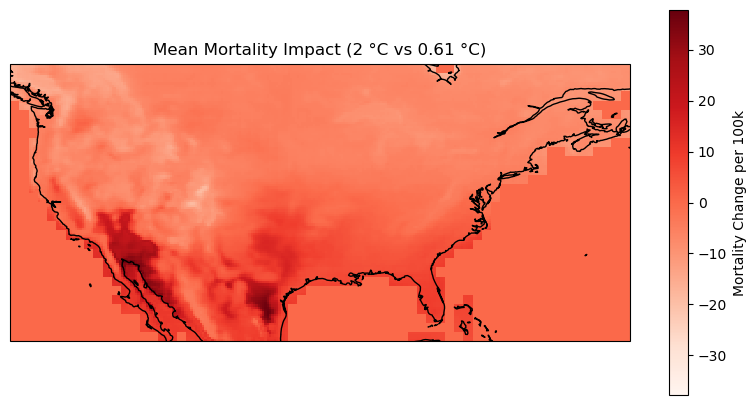

In [11]:
'''
Find the impacts in each bin across models, then find the mean in each bin from the different models. 
Then plot the data
'''

impact_dng_all  = xr.concat(impact_dng_list, dim='model').assign_coords(model=model_labels)
impact_dng_mean = impact_dng_all.mean(dim='model')

def plot_map(data, title, cbar_label):
    
    fig = plt.figure(figsize=(10, 5))
    ax = plt.axes(projection=ccrs.PlateCarree())
    data.plot(ax=ax, cmap='Reds', cbar_kwargs={'label': cbar_label})
    ax.coastlines()
    ax.set_title(title)
    plt.show()
    
plot_map(impact_dng_mean, "Mean Mortality Impact (2 °C vs 0.61 °C)", "Mortality Change per 100k")


In [ ]:
'''
Rebinning for GDP damage function
'''

In [12]:
df_new = df.copy()

In [13]:
dmgf_dnh = xr.DataArray([0.000234,0.000126,-0.000144,-0.000269,-0.000322,-0.000195,-0.000119,-0.000074,-0.000003,-0.000036,
                         0,-0.000111,-0.000311,-0.000294,-0.000585,-0.000646,-0.000757],
                           dims=['bin'],coords=[np.arange(1,18)])
bins_dnh = np.append(np.append(-np.inf,np.arange(-15,31,3)+273.15),np.inf)
bin_name_dnh = '_dnh'

In [14]:
dmgf_dnh_3C = dmgf_dnh.rename({'bin':'bin3C'})

dmgf_dnh_3C = dmgf_dnh_3C.assign_coords(bin3C = ('bin3C', np.arange(dmgf_dnh_3C.sizes['bin3C'])))

In [15]:
def rebin_to_3C_by_groupby(da):
   
    edges_C = np.concatenate(([-np.inf], np.arange(-15, 31, 3), [np.inf]))
    edges_K = edges_C + 273.15

    mid_C = (edges_C[:-1] + edges_C[1:]) / 2

    fine_vals = da['bin_f'].values
    indices = np.digitize(fine_vals, edges_K) - 1

    da2 = da.assign_coords(bin3C=('bin_f', indices))

    rebinned = da2.groupby('bin3C').sum(dim='bin_f')

    rebinned = rebinned.assign_coords({'bin3C':np.arange(rebinned.sizes['bin3C']),'mid_C_degC': ('bin3C', mid_C)})
    
    return rebinned


In [16]:
impact_dnh_list = []
model_labels   = []


for i, row in df_new.iterrows():
    ds = xr.open_zarr(row['path'])

    old_g2  = (ds['bins_behrer'].sel(gwl=2.0,  method='nearest').transpose('bin_f','lat','lon'))
    old_g06 = (ds['bins_behrer'].sel(gwl=0.61, method='nearest').transpose('bin_f','lat','lon'))

    reb2  = rebin_to_3C_by_groupby(old_g2)
    reb06 = rebin_to_3C_by_groupby(old_g06)

    reb2  = reb2.assign_coords(bin3C=('bin3C', np.arange(reb2.sizes['bin3C'])))
    reb06 = reb06.assign_coords(bin3C=('bin3C', np.arange(reb06.sizes['bin3C'])))

    diff_3C = reb2 - reb06
    
    impact_dnh = (diff_3C * dmgf_dnh_3C).sum(dim='bin3C')

    impact_dnh_list.append(impact_dnh)
    model_labels.append(row['model'])


In [17]:
impact_dnh_all  = xr.concat(impact_dnh_list, dim='model') \
                   .assign_coords(model=model_labels)
impact_dnh_mean = impact_dnh_all.mean(dim='model')

def plot_map(data, title, cbar_label):
   
    fig = plt.figure(figsize=(10, 5))
    ax = plt.axes(projection=ccrs.PlateCarree())
    data.plot(ax=ax, cmap='Reds', cbar_kwargs={'label': cbar_label})
    ax.coastlines()
    ax.set_title(title)
    plt.show()


In [18]:
print(dmgf_dnh.dims)
dmgf_3F = dmgf_dnh.rename({'bin':'bin3F'})
print(dmgf_3F.dims)

('bin',)
('bin3F',)


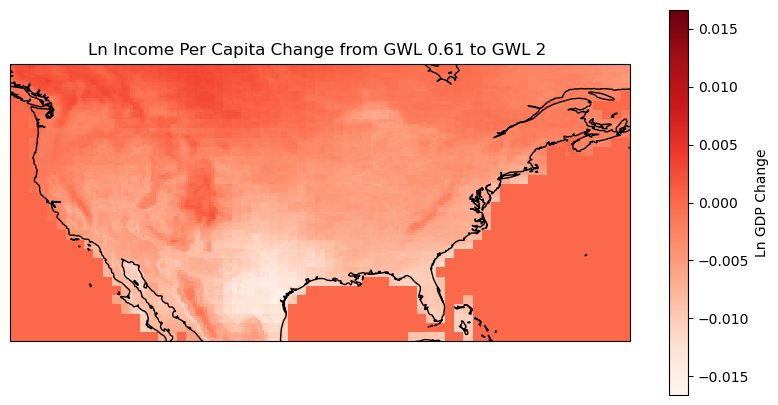

In [19]:
plot_map(impact_dnh, "Ln Income Per Capita Change from GWL 0.61 to GWL 2 ", "Ln GDP Change")


In [20]:
'''
Test Phoenix region
'''

region = {'lat': slice(32.5, 34.5),'lon': slice(-113.0, -111.0)}

impact = (diff_10F * dmgf_10F).sum(dim='bin10F')

phoenix = impact.sel(lat=region['lat'], lon=region['lon'])

mean_imp = float(phoenix.mean().compute().item())
min_imp  = float(phoenix.min().compute().item())
max_imp  = float(phoenix.max().compute().item())

print(f"Phoenix mortality impact (per grid cell):")
print(f"  mean = {mean_imp:.3f}")
print(f"  min  = {min_imp:.3f}")
print(f"  max  = {max_imp:.3f}")

#phoenix

Phoenix mortality impact (per grid cell):
  mean = 5.944
  min  = -0.264
  max  = 12.330


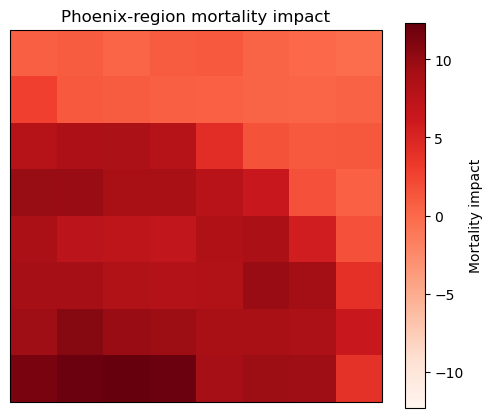

In [21]:
'''
Plot Phoenix region mortality impacts
'''

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(6,5))
phoenix.plot(ax=ax, cmap='Reds', cbar_kwargs={'label':'Mortality impact'})
ax.coastlines();
ax.set_title('Phoenix-region mortality impact');
plt.show()
